## Libraries

In [25]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from Bio.Seq import Seq
from Bio import SeqIO
from Bio import Align
from Bio import AlignIO
from Bio.Align import substitution_matrices
from Bio.Data import IUPACData
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.SeqRecord import SeqRecord
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

'''import cafaeval
from cafaeval.evaluation import cafa_eval
from cafaeval.parser import obo_parser, gt_parser'''

from pathlib import Path
import os

import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Creating the path to the main folder we are going to use to create our datasets

In [26]:
# Path to train data
training_data_path = Path('../data/train')

# Path to test data
test_data_path = Path('../data/test')

# Path to baseline data
baseline_data_path = Path('../data/baseline')


# Training Set

In this section we are **creating the Training Set**, fusing togheter the data from:
- _train_set.tsv_
- _train_ids.txt_
- _train.fasta_
- _train_embeddings.h5_
- _train_protein2ipr.dat_
- _go-basic.obo_

### Extracting `train_set.tsv`

In [27]:
train_set = pd.read_csv(training_data_path / 'train_set.tsv', sep='\t')

# Rename Protein_ID and aspect columns
train_set.rename(columns={'Protein_ID': 'ID', 'aspect' : 'sub_ontology'}, inplace=True)

# Display the first few rows of the train set
train_set.head()

,ID,sub_ontology,GO_term
0,P91124,cellular_component,GO:0005575
1,P91124,cellular_component,GO:0110165
2,P91124,cellular_component,GO:0005737
3,P91124,cellular_component,GO:0005622
4,P91124,cellular_component,GO:0043226


### Extracting `train_ids.txt`

In [28]:
# Extracting train_ids.txt
with open(training_data_path / 'train_ids.txt', 'r') as file:
    train_ids = file.read().splitlines()

# Display the first few IDs to verify
print(train_ids[:5])

['P91124', 'Q55DL5', 'O81027', 'Q04418', 'Q8IXT2']


In [29]:
if len(train_ids) == len(train_set['ID'].unique()):
    print(f"The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set ({len(train_ids)}).\n"
          "Proceeding with the analysis.")

The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set (123969).
Proceeding with the analysis.


### Extracting `train.fasta`

In [30]:
train_fasta_list = list(SeqIO.parse(training_data_path / 'train.fasta', 'fasta'))

# Print the first sequence to verify
print(train_fasta_list[0])

ID: P91124
Name: P91124
Description: P91124
Number of features: 0
Seq('MAAQFYERNTSGMNADRFMTRLTDESTVNTMQRHYWTARQFIRTKLGKKEDEHL...NLL')


Let's transform it into a DataFrame

In [31]:
# Extract relevant information from SeqRecord
train_fasta_dict = [{
    'ID': record.id,
    'name': record.name,
    'description': record.description,
    'num_features': len(record.features),
    'sequence': record.seq,
} for record in train_fasta_list]

# Create a DataFrame from the extracted data
train_fasta = pd.DataFrame(train_fasta_dict)

# Display the DataFrame
train_fasta.head()

,ID,name,description,num_features,sequence
0,P91124,P91124,P91124,0,"(M, A, A, Q, F, Y, E, R, N, T, S, G, M, N, A, ..."
1,Q55DL5,Q55DL5,Q55DL5,0,"(M, S, E, I, L, I, D, S, E, L, L, S, C, P, I, ..."
2,O81027,O81027,O81027,0,"(M, Q, W, N, G, V, R, R, A, H, S, I, W, C, K, ..."
3,Q04418,Q04418,Q04418,0,"(M, D, L, L, G, D, I, V, E, K, D, T, S, D, S, ..."
4,Q8IXT2,Q8IXT2,Q8IXT2,0,"(M, E, P, S, D, M, P, A, G, Y, H, C, P, L, D, ..."


Checking if `ID`, `name` and `description` have the same information

In [32]:
# Checking for differences between the ID and name columns
diff_id_name = sum(train_fasta['ID'] != train_fasta['name'])

# Checking for differences between the ID and description columns
diff_id_description = sum(train_fasta['ID'] != train_fasta['description'])

print(f"We have a total of {diff_id_name} differences between the ID and name columns.\nWe have a total of {diff_id_description} differences between the ID and description columns.")

We have a total of 0 differences between the ID and name columns.
We have a total of 0 differences between the ID and description columns.


Checking if `num_features` has value different from 0

In [33]:
num_features_values = sum(train_fasta['num_features'] != 0)

print(f"We have a total of {num_features_values} sequences with features.")

We have a total of 0 sequences with features.


**Nice!**

We found that `ID`, `name` and `description` columns are the same. We can remove two of them (`name`, `descritpion`). 

In the same way we saw that `num_features` is not very informative since it has only 0, let's remove it as well



In [34]:
train_fasta.drop(columns=['name', 'description', 'num_features'], inplace=True)


train_fasta.head()

,ID,sequence
0,P91124,"(M, A, A, Q, F, Y, E, R, N, T, S, G, M, N, A, ..."
1,Q55DL5,"(M, S, E, I, L, I, D, S, E, L, L, S, C, P, I, ..."
2,O81027,"(M, Q, W, N, G, V, R, R, A, H, S, I, W, C, K, ..."
3,Q04418,"(M, D, L, L, G, D, I, V, E, K, D, T, S, D, S, ..."
4,Q8IXT2,"(M, E, P, S, D, M, P, A, G, Y, H, C, P, L, D, ..."


### Extracting `train_embeddings.h5`

In [35]:
filename = "train_embeddings.h5"

data_list = []

with h5py.File(training_data_path / filename, "r") as f:
    for dataset_name in f.keys():
        dataset = f[dataset_name][:]
        data_list.append([dataset_name, dataset])

train_embeddings = pd.DataFrame(data_list, columns=["ID", "embeddings"])

train_embeddings.head()

,ID,embeddings
0,A0A009IHW8,"[0.0682, -0.04648, 0.001752, -0.00858, 0.00376..."
1,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243..."
2,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788..."
3,A0A023FBW4,"[0.002447, 0.007053, 0.06445, 0.00727, -0.0335..."
4,A0A023FBW7,"[0.04932, 0.02069, 0.10864, 0.01634, -0.05106,..."


### Extracting `train_protein2ipr.dat`

In [36]:
train_protein2ipr = pd.read_csv(training_data_path / 'train_protein2ipr.dat', sep='\t')

# Rename Protein_ID and aspect columns
train_protein2ipr.columns = ['ID', 'ipr', 'domain', 'familyID', 'start', 'end']

# Display the first few rows of the train set
train_protein2ipr.head()

,ID,ipr,domain,familyID,start,end
0,A0A009IHW8,IPR000157,Toll/interleukin-1 receptor homology (TIR) domain,PS50104,133,266
1,A0A009IHW8,IPR000157,Toll/interleukin-1 receptor homology (TIR) domain,SM00255,134,258
2,A0A009IHW8,IPR035897,Toll/interleukin-1 receptor homology (TIR) dom...,G3DSA:3.40.50.10140,80,266
3,A0A009IHW8,IPR035897,Toll/interleukin-1 receptor homology (TIR) dom...,SSF52200,128,249
4,A0A021WW32,IPR006910,"Rad21/Rec8-like protein, N-terminal",PF04825,1,103


In [37]:
# Group by 'ID' and aggregate other columns into lists
train_protein2ipr_grouped = train_protein2ipr.groupby('ID').agg(lambda x: tuple(x)).reset_index()

print(f"Train protein2ipr ({train_protein2ipr.shape}):")
train_protein2ipr_grouped.head()

Train protein2ipr ((1103545, 6)):


,ID,ipr,domain,familyID,start,end
0,A0A009IHW8,"(IPR000157, IPR000157, IPR035897, IPR035897)",(Toll/interleukin-1 receptor homology (TIR) do...,"(PS50104, SM00255, G3DSA:3.40.50.10140, SSF52200)","(133, 134, 80, 128)","(266, 258, 266, 249)"
1,A0A021WW32,"(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)"
2,A0A021WZA4,"(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)"
3,A0A023FBW7,"(IPR045797,)","(Evasins Class A,)","(PF19429,)","(38,)","(110,)"
4,A0A023FDY8,"(IPR045797,)","(Evasins Class A,)","(PF19429,)","(38,)","(110,)"


Still have to understand what *tizio, caio, sempronio* are.

### Extracting `go-basic.obo`

In [38]:
import re

file_path = "../data/train/go-basic.obo"  # Replace with your file path

# Step 1: Initialize storage for GO terms
go_terms = []

# Step 2: Parse the .obo file
with open(file_path, 'r') as file:
    current_term = {}
    for line in file:
        line = line.strip()
        
        # Start of a new term
        if line == "[Term]":
            if current_term:  # Save the previous term
                go_terms.append(current_term)
            current_term = {}  # Start a new term
            
        elif line.startswith("id:"):
            current_term['ID'] = line.split("id: ")[1]
            
        elif line.startswith("alt_id:"):
            alt_id = line.split("alt_id: ")[1]
            current_term.setdefault('alt_ids', []).append(alt_id)
            
        elif line.startswith("name:"):
            current_term['name'] = line.split("name: ")[1]
            
        elif line.startswith("namespace:"):
            current_term['namespace'] = line.split("namespace: ")[1]
            
        elif line.startswith("is_a"):
            match = re.search(r"GO:\d+", line)  # Search for GO ID
            if match:  # Check if a match was found
                is_a_id = match.group()
                current_term.setdefault('is_a', []).append(is_a_id)
                
        elif line.startswith("relationship: part_of"):
            match = re.search(r"GO:\d+", line)  # Search for GO ID
            if match:  # Check if a match was found
                part_of_id = match.group()
                current_term.setdefault('part_of', []).append(part_of_id)

            
    # Add the last term
    if current_term:
        go_terms.append(current_term)

# Step 3: Create a unified list of all IDs (primary and alt_ids)
expanded_terms = []
for term in go_terms:
    primary_id = term['ID']
    alt_ids = term.get('alt_ids', [])
    all_ids = [primary_id] + alt_ids
    
    for term_id in all_ids:
        expanded_terms.append({
            'ID': term_id,
            'name': term.get('name'),
            'namespace': term.get('namespace'),
            'is_a': term.get('is_a', []),
            'part_of': term.get('part_of', [])
        })

# Step 4: Convert to a DataFrame
df = pd.DataFrame(expanded_terms)

# Step 5: Filter by namespace and explode relationships
df_is_a = df.explode('is_a').dropna(subset=['is_a'])
df_part_of = df.explode('part_of').dropna(subset=['part_of'])


print("All IDs with namespaces:")
df.head()

All IDs with namespaces:


,ID,name,namespace,is_a,part_of
0,GO:0000001,mitochondrion inheritance,biological_process,"[GO:0048308, GO:0048311]",[]
1,GO:0000002,mitochondrial genome maintenance,biological_process,[GO:0007005],[]
2,GO:0000003,reproduction,biological_process,[GO:0008150],[]
3,GO:0019952,reproduction,biological_process,[GO:0008150],[]
4,GO:0050876,reproduction,biological_process,[GO:0008150],[]


In [39]:
print("'is_a' relationships:")
df_is_a.head()

'is_a' relationships:


,ID,name,namespace,is_a,part_of
0,GO:0000001,mitochondrion inheritance,biological_process,GO:0048308,[]
0,GO:0000001,mitochondrion inheritance,biological_process,GO:0048311,[]
1,GO:0000002,mitochondrial genome maintenance,biological_process,GO:0007005,[]
2,GO:0000003,reproduction,biological_process,GO:0008150,[]
3,GO:0019952,reproduction,biological_process,GO:0008150,[]


In [40]:
print("'part_of' relationships:")
df_part_of.head()

'part_of' relationships:


,ID,name,namespace,is_a,part_of
16,GO:0000015,phosphopyruvate hydratase complex,cellular_component,[GO:1902494],GO:0005829
22,GO:0000022,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0000070
22,GO:0000022,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0007052
23,GO:1905121,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0000070
23,GO:1905121,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0007052


## Merging all previous extractions

Let us collect the dataframes and check lengths. Noting that:
- _train_set.tsv_ contains the proteins, their GO annotations and their corresponding aspects which will be used to subdivde it into three separate datasets
- _train.fasta_ and _train_embeddings.h5_ can be grouped together since they refers to the whole input
- _train_protein2ipr.dat_
- _go-basic.obo_

In [41]:
def group_and_combine(df, sub_ontology_value):
    return df[df['sub_ontology'] == sub_ontology_value].groupby('ID')['GO_term'].apply(tuple).reset_index()

# Create three dataframes for each sub_ontology value
df_CC = group_and_combine(train_set, 'cellular_component')
df_MF = group_and_combine(train_set, 'molecular_function')
df_BP = group_and_combine(train_set, 'biological_process')

print(f"Shapes: CC {df_CC.shape}, MF {df_MF.shape}, BP {df_BP.shape}")

print(f"Cellular Component ({df_CC.shape[0]}):")
df_CC.head()

Shapes: CC (84638, 2), MF (55698, 2), BP (83064, 2)
Cellular Component (84638):


,ID,GO_term
0,A0A021WW32,"(GO:0005575, GO:0110165, GO:0000785, GO:003299..."
1,A0A021WZA4,"(GO:0005575, GO:0110165, GO:0071944, GO:000588..."
2,A0A023GPJ3,"(GO:0005575, GO:0110165, GO:0005622, GO:000582..."
3,A0A023GUT0,"(GO:0005575, GO:0110165, GO:0005576, GO:0005615)"
4,A0A023IM54,"(GO:0005575, GO:0005737, GO:0042175, GO:003299..."


In [42]:
combined_train = pd.merge(train_embeddings, train_fasta, on='ID')
combined_train = pd.merge(combined_train, train_protein2ipr_grouped, on='ID', how='left')

missing_rows = combined_train[combined_train['ipr'].isna()].shape[0]
print(f"Number of rows missing from train_protein2ipr_grouped: {missing_rows}")

# combined_train = combined_train.drop('domain', axis=1)

print(f"Combined DataFrame shape: {combined_train.shape}")
combined_train.head()

Number of rows missing from train_protein2ipr_grouped: 6522
Combined DataFrame shape: (123969, 8)


,ID,embeddings,sequence,ipr,domain,familyID,start,end
0,A0A009IHW8,"[0.0682, -0.04648, 0.001752, -0.00858, 0.00376...","(M, S, L, E, Q, K, K, G, A, D, I, I, S, K, I, ...","(IPR000157, IPR000157, IPR035897, IPR035897)",(Toll/interleukin-1 receptor homology (TIR) do...,"(PS50104, SM00255, G3DSA:3.40.50.10140, SSF52200)","(133, 134, 80, 128)","(266, 258, 266, 249)"
1,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...","(M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...","(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)"
2,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788...","(M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...","(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)"
3,A0A023FBW4,"[0.002447, 0.007053, 0.06445, 0.00727, -0.0335...","(M, T, S, H, G, A, V, K, I, A, I, F, A, V, I, ...",NaN,NaN,NaN,NaN,NaN
4,A0A023FBW7,"[0.04932, 0.02069, 0.10864, 0.01634, -0.05106,...","(M, K, V, L, L, Y, I, A, A, S, C, L, M, L, L, ...","(IPR045797,)","(Evasins Class A,)","(PF19429,)","(38,)","(110,)"


In [43]:
# Merge combined_train with df_ab
df_CC_full= pd.merge(combined_train, df_CC, on='ID', how='right')
df_MF_full= pd.merge(combined_train, df_MF, on='ID', how='right')
df_BP_full= pd.merge(combined_train, df_BP, on='ID', how='right')

print(f"Shapes: CC {df_CC_full.shape}, MF {df_MF_full.shape}, BP {df_BP_full.shape}")

print(f"Full df CC {df_CC_full.shape}:")
df_CC_full.head()

Shapes: CC (84638, 9), MF (55698, 9), BP (83064, 9)
Full df CC (84638, 9):


,ID,embeddings,sequence,ipr,domain,familyID,start,end,GO_term
0,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...","(M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...","(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)","(GO:0005575, GO:0110165, GO:0000785, GO:003299..."
1,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788...","(M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...","(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)","(GO:0005575, GO:0110165, GO:0071944, GO:000588..."
2,A0A023GPJ3,"[0.01512, 0.01102, 0.0217, -0.02512, 0.0396, 0...","(M, D, R, D, A, E, E, G, R, P, L, S, L, V, N, ...","(IPR013087, IPR013087, IPR013087, IPR013087, I...","(Zinc finger C2H2-type, Zinc finger C2H2-type,...","(PF00096, PF00096, PF00096, PF00096, PS00028, ...","(644, 956, 983, 1013, 197, 646, 674, 957, 985,...","(666, 977, 1005, 1034, 218, 666, 694, 977, 100...","(GO:0005575, GO:0110165, GO:0005622, GO:000582..."
3,A0A023GUT0,"[-0.00414, -0.01288, 0.0716, 0.01605, -0.03983...","(M, R, C, P, G, V, S, L, W, G, L, L, C, L, G, ...","(IPR000065, IPR000065, IPR009079, IPR009079)","(Leptin, Leptin, Four-helical cytokine-like, c...","(PF02024, PTHR11724, G3DSA:1.20.1250.10, SSF47...","(28, 7, 24, 29)","(172, 172, 172, 172)","(GO:0005575, GO:0110165, GO:0005576, GO:0005615)"
4,A0A023IM54,"[-0.01651, 0.02525, 0.04333, 0.01558, -0.01678...","(M, K, L, L, P, L, L, V, V, V, A, L, G, L, A, ...","(IPR003006, IPR003597, IPR003597, IPR007110, I...",(Immunoglobulin/major histocompatibility compl...,"(PS00290, PF07654, SM00407, PS50835, PR01669, ...","(382, 312, 312, 294, 55, 135, 199, 247, 271, 3...","(388, 391, 394, 401, 63, 146, 216, 261, 287, 3...","(GO:0005575, GO:0005737, GO:0042175, GO:003299..."


In [44]:
x_df_CC = df_CC_full.iloc[:, :-1]
y_df_CC = df_CC_full.iloc[:, -1]
x_df_MF = df_MF_full.iloc[:, :-1]
y_df_MF = df_MF_full.iloc[:, -1]
x_df_BP = df_BP_full.iloc[:, :-1]
y_df_BP = df_BP_full.iloc[:, -1]

print(f"Shapes: x_df_CC {x_df_CC.shape}, y_df_CC {y_df_CC.shape}, x_df_MF {x_df_MF.shape}, y_df_MF {y_df_MF.shape}, x_df_BP {x_df_BP.shape}, y_df_BP {y_df_BP.shape}")

print("CC Input:")
x_df_CC.head()

Shapes: x_df_CC (84638, 8), y_df_CC (84638,), x_df_MF (55698, 8), y_df_MF (55698,), x_df_BP (83064, 8), y_df_BP (83064,)
CC Input:


,ID,embeddings,sequence,ipr,domain,familyID,start,end
0,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...","(M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...","(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)"
1,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788...","(M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...","(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)"
2,A0A023GPJ3,"[0.01512, 0.01102, 0.0217, -0.02512, 0.0396, 0...","(M, D, R, D, A, E, E, G, R, P, L, S, L, V, N, ...","(IPR013087, IPR013087, IPR013087, IPR013087, I...","(Zinc finger C2H2-type, Zinc finger C2H2-type,...","(PF00096, PF00096, PF00096, PF00096, PS00028, ...","(644, 956, 983, 1013, 197, 646, 674, 957, 985,...","(666, 977, 1005, 1034, 218, 666, 694, 977, 100..."
3,A0A023GUT0,"[-0.00414, -0.01288, 0.0716, 0.01605, -0.03983...","(M, R, C, P, G, V, S, L, W, G, L, L, C, L, G, ...","(IPR000065, IPR000065, IPR009079, IPR009079)","(Leptin, Leptin, Four-helical cytokine-like, c...","(PF02024, PTHR11724, G3DSA:1.20.1250.10, SSF47...","(28, 7, 24, 29)","(172, 172, 172, 172)"
4,A0A023IM54,"[-0.01651, 0.02525, 0.04333, 0.01558, -0.01678...","(M, K, L, L, P, L, L, V, V, V, A, L, G, L, A, ...","(IPR003006, IPR003597, IPR003597, IPR007110, I...",(Immunoglobulin/major histocompatibility compl...,"(PS00290, PF07654, SM00407, PS50835, PR01669, ...","(382, 312, 312, 294, 55, 135, 199, 247, 271, 3...","(388, 391, 394, 401, 63, 146, 216, 261, 287, 3..."


In [45]:
print("CC Target:")
y_df_CC.head()

CC Target:


0    (GO:0005575, GO:0110165, GO:0000785, GO:003299...
1    (GO:0005575, GO:0110165, GO:0071944, GO:000588...
2    (GO:0005575, GO:0110165, GO:0005622, GO:000582...
3     (GO:0005575, GO:0110165, GO:0005576, GO:0005615)
4    (GO:0005575, GO:0005737, GO:0042175, GO:003299...
Name: GO_term, dtype: object

# Test set

In this section we are **creating the Test set**, fusing togheter the data from:
- _test_ids.txt_
- _test.fasta_
- _test_embeddings.h5_
- _test_protein2ipr.dat_
- _blast_test_results.tsv_

### Extracting `test_ids.txt`

In [46]:
# Extracting test_ids.txt
with open(test_data_path / 'test_ids.txt', 'r') as file:
    test_ids = file.read().splitlines()

# Display the first few IDs to verify
print(test_ids[:5])

['O43747', 'Q969H0', 'Q9JMA2', 'P18065', 'A0A8I6AN32']


### Extracting `test.fasta`

In [47]:
test_fasta_list = list(SeqIO.parse(test_data_path / 'test.fasta', 'fasta'))

# Print the first sequence to verify
print(test_fasta_list[0])

ID: O43747
Name: O43747
Description: O43747
Number of features: 0
Seq('MPAPIRLRELIRTIRTARTQAEEREMIQKECAAIRSSFREEDNTYRCRNVAKLL...SWQ')


In [48]:
# Extract relevant information from SeqRecord
test_fasta_dict = [{
    'ID': record.id,
    'name': record.name,
    'description': record.description,
    'num_features': len(record.features),
    'sequence': record.seq,
} for record in test_fasta_list]

# Create a DataFrame from the extracted data
test_fasta = pd.DataFrame(test_fasta_dict)

# Display the DataFrame
test_fasta.head()

,ID,name,description,num_features,sequence
0,O43747,O43747,O43747,0,"(M, P, A, P, I, R, L, R, E, L, I, R, T, I, R, ..."
1,Q969H0,Q969H0,Q969H0,0,"(M, N, Q, E, L, L, S, V, G, S, K, R, R, R, T, ..."
2,Q9JMA2,Q9JMA2,Q9JMA2,0,"(M, A, A, V, G, S, P, G, S, L, E, S, A, P, R, ..."
3,P18065,P18065,P18065,0,"(M, L, P, R, V, G, C, P, A, L, P, L, P, P, P, ..."
4,A0A8I6AN32,A0A8I6AN32,A0A8I6AN32,0,"(M, A, S, N, D, Y, T, Q, Q, A, T, Q, S, Y, G, ..."


Let's check if ID, name and description are the same thing, as well as seeing if num_features has relevant information.

In [49]:
# Checking for differences between the ID and name columns
diff_id_name = sum(test_fasta['ID'] != test_fasta['name'])

# Checking for differences between the ID and description columns
diff_id_description = sum(test_fasta['ID'] != test_fasta['description'])

print(f"We have a total of {diff_id_name} differences between the ID and name columns.\nWe have a total of {diff_id_description} differences between the ID and description columns.")

We have a total of 0 differences between the ID and name columns.
We have a total of 0 differences between the ID and description columns.


In [50]:
num_features_values = sum(test_fasta['num_features'] != 0)

print(f"We have a total of {num_features_values} sequences with features.")

We have a total of 0 sequences with features.


Let's drop the useless columns, as before

In [51]:
test_fasta.drop(columns=['name', 'description', 'num_features'], inplace=True)


test_fasta.head()

,ID,sequence
0,O43747,"(M, P, A, P, I, R, L, R, E, L, I, R, T, I, R, ..."
1,Q969H0,"(M, N, Q, E, L, L, S, V, G, S, K, R, R, R, T, ..."
2,Q9JMA2,"(M, A, A, V, G, S, P, G, S, L, E, S, A, P, R, ..."
3,P18065,"(M, L, P, R, V, G, C, P, A, L, P, L, P, P, P, ..."
4,A0A8I6AN32,"(M, A, S, N, D, Y, T, Q, Q, A, T, Q, S, Y, G, ..."


Let's also check if the IDs are the same as the ones in the txt file

In [52]:
len_ID = len(test_fasta['ID'].unique()) # assigned because gave problem on else statement print

if len(test_ids) == len_ID:
    print(f"The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set ({len(test_ids)}).\n"
          "Proceeding with the analysis.")
else:
    print(f'The numbers are not the same: test_ids are {len(test_ids)}, while the length of the fasta file is {len_ID})')

The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set (1000).
Proceeding with the analysis.


### Extracting `test_embeddings.h5`

In [53]:
data_list = []

with h5py.File(test_data_path / "test_embeddings.h5", "r") as f:
    for dataset_name in f.keys():
        dataset = f[dataset_name][:]
        data_list.append([dataset_name, dataset])

test_embeddings = pd.DataFrame(data_list, columns=["ID", "embeddings"])

test_embeddings.head()

,ID,embeddings
0,A0A0B4JCV4,"[0.00979, -0.03973, 0.03653, -0.006447, -0.040..."
1,A0A0B4KHT0,"[0.02786, -0.01154, 0.008865, -0.01765, 0.0073..."
2,A0A0B4P506,"[0.01643, 0.01802, 0.03702, -0.0591, 0.0356, 0..."
3,A0A0G2K1A2,"[0.00882, 0.0835, -0.001374, -0.0003645, -0.06..."
4,A0A0G2K1V4,"[0.0659, 0.0929, -0.001803, 0.0226, 0.0383, 0...."


### Extracting `test_protein2ipr.dat`

In [54]:
test_protein2ipr = pd.read_csv(test_data_path / 'test_protein2ipr.dat', sep='\t')

# Rename Protein_ID and aspect columns
test_protein2ipr.columns = ['ID', 'ipr', 'domain', 'familyID', 'start', 'end']

# Remove 'domain' that is useless
test_protein2ipr.drop('domain', axis=1)

test_protein2ipr.head()

,ID,ipr,domain,familyID,start,end
0,A0A0B4JCV4,IPR039915,TACC family,PTHR13924,38,1206
1,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PF00643,177,219
2,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PF00643,236,274
3,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PS50119,173,220
4,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PS50119,235,282


In [55]:
# Group by 'ID' and aggregate other columns into lists
test_protein2ipr_grouped = test_protein2ipr.groupby('ID').agg(lambda x: tuple(x)).reset_index()

print(f"Test protein2ipr ({test_protein2ipr.shape}):")
test_protein2ipr_grouped.head()

Test protein2ipr ((11263, 6)):


,ID,ipr,domain,familyID,start,end
0,A0A0B4JCV4,"(IPR039915,)","(TACC family,)","(PTHR13924,)","(38,)","(1206,)"
1,A0A0B4KHT0,"(IPR000315, IPR000315, IPR000315, IPR000315, I...","(B-box-type zinc finger, B-box-type zinc finge...","(PF00643, PF00643, PS50119, PS50119, SM00336, ...","(177, 236, 173, 235, 173, 235, 976, 826, 988, ...","(219, 274, 220, 282, 220, 276, 1048, 839, 1004..."
2,A0A0B4P506,"(IPR003417, IPR003417, IPR036552, IPR036552)","(Core-binding factor, beta subunit, Core-bindi...","(PF02312, PTHR10276, G3DSA:2.40.250.10, SSF50723)","(1, 1, 1, 4)","(164, 168, 142, 140)"
3,A0A0G2K1A2,"(IPR010255, IPR019791, IPR019791, IPR019791, I...","(Haem peroxidase superfamily, Haem peroxidase,...","(SSF48113, PF03098, PR00457, PR00457, PR00457,...","(142, 148, 172, 226, 374, 392, 417, 470, 598, ...","(718, 692, 183, 241, 392, 412, 443, 480, 618, ..."
4,A0A0G2K1V4,"(IPR000048, IPR000048, IPR001609, IPR001609, I...","(IQ motif, EF-hand binding site, IQ motif, EF-...","(PS50096, SM00015, PF00063, PR00193, PR00193, ...","(789, 788, 89, 116, 172, 228, 459, 513, 86, 80...","(818, 810, 774, 135, 197, 255, 487, 541, 786, ..."


### Extracting `blast_test_results.tsv`

### Merging

In [56]:
combined_test = pd.merge(test_embeddings, test_fasta, on='ID')
combined_test = pd.merge(combined_test, test_protein2ipr_grouped, on='ID', how='left')

missing_rows = combined_test[combined_test['ipr'].isna()].shape[0]
print(f"Number of rows missing from train_protein2ipr_grouped: {missing_rows}")

print(f"Combined DataFrame shape: {combined_test.shape}")
combined_test.head()

Number of rows missing from train_protein2ipr_grouped: 19
Combined DataFrame shape: (1000, 8)


,ID,embeddings,sequence,ipr,domain,familyID,start,end
0,A0A0B4JCV4,"[0.00979, -0.03973, 0.03653, -0.006447, -0.040...","(M, E, F, D, D, A, E, N, G, L, G, M, G, F, G, ...","(IPR039915,)","(TACC family,)","(PTHR13924,)","(38,)","(1206,)"
1,A0A0B4KHT0,"[0.02786, -0.01154, 0.008865, -0.01765, 0.0073...","(M, D, M, D, L, E, Q, L, K, N, D, F, L, P, L, ...","(IPR000315, IPR000315, IPR000315, IPR000315, I...","(B-box-type zinc finger, B-box-type zinc finge...","(PF00643, PF00643, PS50119, PS50119, SM00336, ...","(177, 236, 173, 235, 173, 235, 976, 826, 988, ...","(219, 274, 220, 282, 220, 276, 1048, 839, 1004..."
2,A0A0B4P506,"[0.01643, 0.01802, 0.03702, -0.0591, 0.0356, 0...","(M, P, R, V, V, P, D, Q, R, S, K, F, E, N, E, ...","(IPR003417, IPR003417, IPR036552, IPR036552)","(Core-binding factor, beta subunit, Core-bindi...","(PF02312, PTHR10276, G3DSA:2.40.250.10, SSF50723)","(1, 1, 1, 4)","(164, 168, 142, 140)"
3,A0A0G2K1A2,"[0.00882, 0.0835, -0.001374, -0.0003645, -0.06...","(M, K, L, F, L, A, L, A, G, L, L, A, P, L, A, ...","(IPR010255, IPR019791, IPR019791, IPR019791, I...","(Haem peroxidase superfamily, Haem peroxidase,...","(SSF48113, PF03098, PR00457, PR00457, PR00457,...","(142, 148, 172, 226, 374, 392, 417, 470, 598, ...","(718, 692, 183, 241, 392, 412, 443, 480, 618, ..."
4,A0A0G2K1V4,"[0.0659, 0.0929, -0.001803, 0.0226, 0.0383, 0....","(M, S, S, D, A, E, M, A, V, F, G, E, A, A, P, ...","(IPR000048, IPR000048, IPR001609, IPR001609, I...","(IQ motif, EF-hand binding site, IQ motif, EF-...","(PS50096, SM00015, PF00063, PR00193, PR00193, ...","(789, 788, 89, 116, 172, 228, 459, 513, 86, 80...","(818, 810, 774, 135, 197, 255, 487, 541, 786, ..."


In [57]:
# Check if combined_train and combined_test have the same columns
print("Combined_train and combined_test have the same columns:" , set(combined_train.columns) == set(combined_test.columns))

Combined_train and combined_test have the same columns: True


# PCA for embeddings

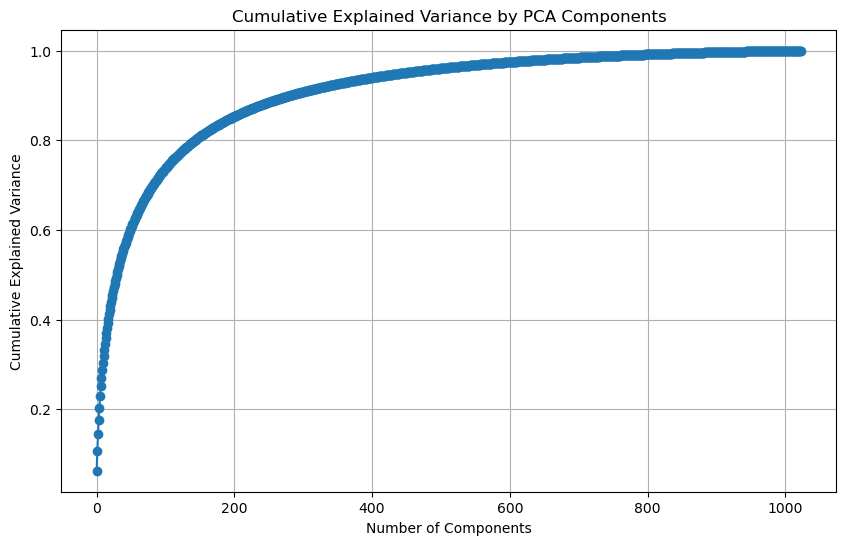

Number of components to retain 90% variance: 282
                                          embeddings  \
0  [0.0682, -0.04648, 0.001752, -0.00858, 0.00376...   
1  [-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...   
2  [0.007904, 0.0877, -0.001715, 0.03766, 0.01788...   
3  [0.002447, 0.007053, 0.06445, 0.00727, -0.0335...   
4  [0.04932, 0.02069, 0.10864, 0.01634, -0.05106,...   

                                  reduced_embeddings  
0  [5.4523606665687225, -5.8758264481705345, 0.08...  
1  [4.133830309520593, -1.0227187856418758, -7.10...  
2  [-4.523184761098723, -1.556923031722572, -3.69...  
3  [10.47872694504401, 1.9959073551785524, 9.1464...  
4  [5.112677477907848, 5.149423232438324, 12.5065...  


In [58]:
# Extract embeddings and convert to NumPy array,
embeddings = np.array(combined_train['embeddings'].tolist())
# Standardize
scaler = StandardScaler()
embeddings_standardized = scaler.fit_transform(embeddings)

# Apply PCA\n",
pca = PCA()
pca.fit(embeddings_standardized)

# Plot cumulative explained variance
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Choose the number of components to retain (in our case 90% of variance)
n_components = np.argmax(np.cumsum(explained_variance) >= 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

# Apply PCA with chosen number of components
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(embeddings_standardized)

#Integrate reduced embeddings into combined_df
combined_train['reduced_embeddings'] = reduced_embeddings.tolist()
print(combined_train[['embeddings', 'reduced_embeddings']].head())

We'll see that considering each df separately doesn't change much.

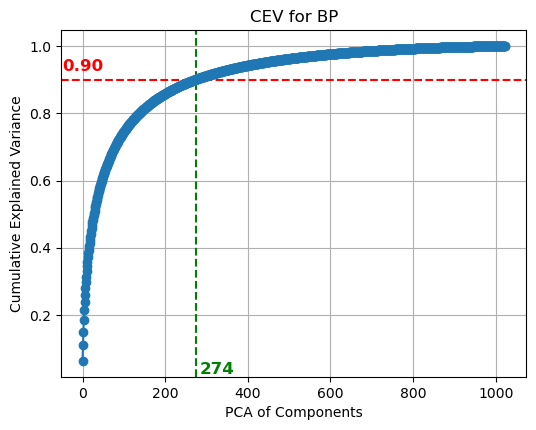

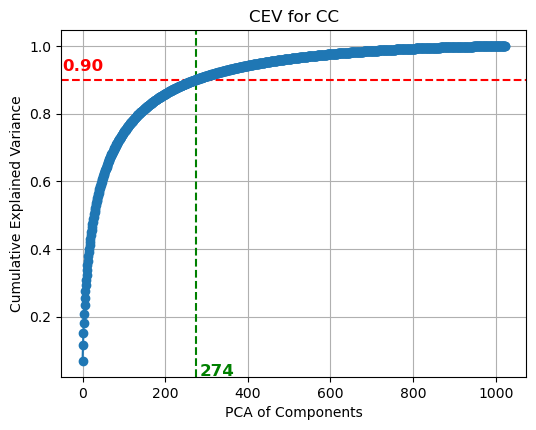

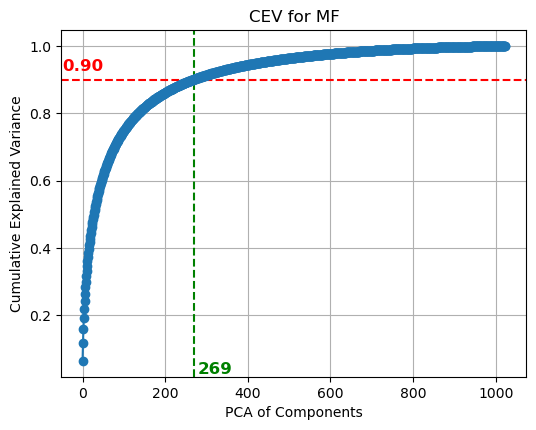

In [63]:
def pca_col(df, name, column_name='embeddings', variance_threshold=0.90):
    embeddings = np.array(df[column_name].tolist())
    
    scaler = StandardScaler()
    embeddings_standardized = scaler.fit_transform(embeddings)
    
    pca = PCA()
    pca.fit(embeddings_standardized)
    explained_variance = pca.explained_variance_ratio_

    # Components to retain (in our case 90% of variance)
    n_components = np.argmax(np.cumsum(explained_variance) >= variance_threshold) + 1
        
    plt.figure(figsize=(6, 4.5))
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    x_value = np.argmax(np.cumsum(explained_variance) >= variance_threshold) + 1
    plt.axvline(x=x_value, color='g', linestyle='--')
    plt.text(x_value + 10, 0.025, f'{x_value}', color='green', size='large', weight='bold')
    plt.text(- 50, variance_threshold + 0.025, f'{variance_threshold:.2f}', color='red', size='large', weight='bold')

    plt.plot(np.cumsum(explained_variance), marker='o')
    plt.title(f'CEV for {name}')
    plt.xlabel('PCA of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()
    
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings_standardized)
    
    # Integrate reduced embeddings into the DataFrame
    df[f'reduced_{column_name}'] = reduced_embeddings.tolist()
    return df

# Apply PCA and add column for each dataset
x_df_BP = pca_col(x_df_BP, 'BP')
x_df_CC = pca_col(x_df_CC, 'CC')
x_df_MF = pca_col(x_df_MF, 'MF')

# CC NN

In [143]:
# Load data
X = x_df_CC['embeddings']  # Assuming embeddings are already reduced
X = pd.DataFrame(X.tolist())  # Convert list of lists to DataFrame

# Preprocess target (MultiLabelBinarizer for multi-label classification)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_df_CC)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
# Convert NumPy array to PyTorch tensor
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

## Models (1 - 4)

In [52]:
# NN1

class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1] 
hidden_sizes = [4096, 2048]    
output_size = y_train.shape[1]   

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
epochs = 75
batch_size = 512

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/75], Loss: 0.0408
Epoch [2/75], Loss: 0.0367
Epoch [3/75], Loss: 0.0330
Epoch [4/75], Loss: 0.0316
Epoch [5/75], Loss: 0.0290
Epoch [6/75], Loss: 0.0274
Epoch [7/75], Loss: 0.0261
Epoch [8/75], Loss: 0.0245
Epoch [9/75], Loss: 0.0232
Epoch [10/75], Loss: 0.0216
Epoch [11/75], Loss: 0.0199
Epoch [12/75], Loss: 0.0201
Epoch [13/75], Loss: 0.0201
Epoch [14/75], Loss: 0.0177
Epoch [15/75], Loss: 0.0181
Epoch [16/75], Loss: 0.0161
Epoch [17/75], Loss: 0.0160
Epoch [18/75], Loss: 0.0156
Epoch [19/75], Loss: 0.0156
Epoch [20/75], Loss: 0.0141
Epoch [21/75], Loss: 0.0141
Epoch [22/75], Loss: 0.0148
Epoch [23/75], Loss: 0.0145
Epoch [24/75], Loss: 0.0130
Epoch [25/75], Loss: 0.0125
Epoch [26/75], Loss: 0.0124
Epoch [27/75], Loss: 0.0123
Epoch [28/75], Loss: 0.0125
Epoch [29/75], Loss: 0.0118
Epoch [30/75], Loss: 0.0117
Epoch [31/75], Loss: 0.0120
Epoch [32/75], Loss: 0.0111
Epoch [33/75], Loss: 0.0106
Epoch [34/75], Loss: 0.0108
Epoch [35/75], Loss: 0.0108
Epoch [36/75], Loss: 0.0099
E

C:\Users\eliat\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [146]:
# Print the model summary
_ = summary(model, input_size=(X_train_tensor.shape[1],))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       4,198,400
|    └─ReLU: 2-2                         --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       8,390,656
|    └─ReLU: 2-5                         --
|    └─Dropout: 2-6                      --
|    └─Linear: 2-7                       1,389,222
|    └─Sigmoid: 2-8                      --
Total params: 13,978,278
Trainable params: 13,978,278
Non-trainable params: 0


In [39]:
# NN2
 
class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.1),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  
hidden_sizes = [4096, 2048]          
output_size = y_train.shape[1]   

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 75
batch_size = 1024

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/75], Loss: 0.0461
Epoch [2/75], Loss: 0.0425
Epoch [3/75], Loss: 0.0386
Epoch [4/75], Loss: 0.0363
Epoch [5/75], Loss: 0.0349
Epoch [6/75], Loss: 0.0331
Epoch [7/75], Loss: 0.0320
Epoch [8/75], Loss: 0.0309
Epoch [9/75], Loss: 0.0291
Epoch [10/75], Loss: 0.0276
Epoch [11/75], Loss: 0.0264
Epoch [12/75], Loss: 0.0249
Epoch [13/75], Loss: 0.0236
Epoch [14/75], Loss: 0.0224
Epoch [15/75], Loss: 0.0214
Epoch [16/75], Loss: 0.0201
Epoch [17/75], Loss: 0.0189
Epoch [18/75], Loss: 0.0181
Epoch [19/75], Loss: 0.0170
Epoch [20/75], Loss: 0.0163
Epoch [21/75], Loss: 0.0150
Epoch [22/75], Loss: 0.0144
Epoch [23/75], Loss: 0.0137
Epoch [24/75], Loss: 0.0128
Epoch [25/75], Loss: 0.0126
Epoch [26/75], Loss: 0.0117
Epoch [27/75], Loss: 0.0113
Epoch [28/75], Loss: 0.0107
Epoch [29/75], Loss: 0.0103
Epoch [30/75], Loss: 0.0099
Epoch [31/75], Loss: 0.0096
Epoch [32/75], Loss: 0.0100
Epoch [33/75], Loss: 0.0096
Epoch [34/75], Loss: 0.0089
Epoch [35/75], Loss: 0.0084
Epoch [36/75], Loss: 0.0079
E

C:\Users\eliat\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
# NN3

class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1] 
hidden_sizes = [2048, 1024]       
output_size = y_train.shape[1] 

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 75
batch_size = 2048

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/75], Loss: 0.0565
Epoch [2/75], Loss: 0.0464
Epoch [3/75], Loss: 0.0458
Epoch [4/75], Loss: 0.0438
Epoch [5/75], Loss: 0.0409
Epoch [6/75], Loss: 0.0395
Epoch [7/75], Loss: 0.0377
Epoch [8/75], Loss: 0.0364
Epoch [9/75], Loss: 0.0355
Epoch [10/75], Loss: 0.0343
Epoch [11/75], Loss: 0.0332
Epoch [12/75], Loss: 0.0324
Epoch [13/75], Loss: 0.0317
Epoch [14/75], Loss: 0.0310
Epoch [15/75], Loss: 0.0306
Epoch [16/75], Loss: 0.0291
Epoch [17/75], Loss: 0.0290
Epoch [18/75], Loss: 0.0280
Epoch [19/75], Loss: 0.0272
Epoch [20/75], Loss: 0.0263
Epoch [21/75], Loss: 0.0260
Epoch [22/75], Loss: 0.0252
Epoch [23/75], Loss: 0.0243
Epoch [24/75], Loss: 0.0241
Epoch [25/75], Loss: 0.0237
Epoch [26/75], Loss: 0.0229
Epoch [27/75], Loss: 0.0225
Epoch [28/75], Loss: 0.0220
Epoch [29/75], Loss: 0.0212
Epoch [30/75], Loss: 0.0206
Epoch [31/75], Loss: 0.0201
Epoch [32/75], Loss: 0.0196
Epoch [33/75], Loss: 0.0192
Epoch [34/75], Loss: 0.0189
Epoch [35/75], Loss: 0.0184
Epoch [36/75], Loss: 0.0180
E

C:\Users\eliat\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
# NN4

class ImprovedMultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(ImprovedMultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.BatchNorm1d(hidden_sizes[0]),  # Batch Normalization
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.BatchNorm1d(hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]
hidden_sizes = [2048, 1024]          
output_size = y_train.shape[1]  

# Initialize the model
model = ImprovedMultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function (Binary Cross-Entropy Loss)
criterion = nn.BCELoss()

# Optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
epochs = 75
batch_size = 1024

def train_model(model, X_train, y_train, optimizer, criterion, scheduler, batch_size, epochs):
    model.train()

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, scheduler, batch_size, epochs)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)

# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nImproved Neural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))

Epoch [1/75], Loss: 4.2606
Epoch [2/75], Loss: 2.5208
Epoch [3/75], Loss: 2.3829
Epoch [4/75], Loss: 2.3422
Epoch [5/75], Loss: 2.3177
Epoch [6/75], Loss: 2.2321
Epoch [7/75], Loss: 2.2052
Epoch [8/75], Loss: 2.1842
Epoch [9/75], Loss: 2.1671
Epoch [10/75], Loss: 2.1523
Epoch [11/75], Loss: 2.0687
Epoch [12/75], Loss: 2.0263
Epoch [13/75], Loss: 2.0071
Epoch [14/75], Loss: 1.9853
Epoch [15/75], Loss: 1.9667
Epoch [16/75], Loss: 1.8777
Epoch [17/75], Loss: 1.8335
Epoch [18/75], Loss: 1.8037
Epoch [19/75], Loss: 1.7827
Epoch [20/75], Loss: 1.7575
Epoch [21/75], Loss: 1.6833
Epoch [22/75], Loss: 1.6419
Epoch [23/75], Loss: 1.6118
Epoch [24/75], Loss: 1.5907
Epoch [25/75], Loss: 1.5664
Epoch [26/75], Loss: 1.5118
Epoch [27/75], Loss: 1.4823
Epoch [28/75], Loss: 1.4591
Epoch [29/75], Loss: 1.4419
Epoch [30/75], Loss: 1.4241
Epoch [31/75], Loss: 1.3864
Epoch [32/75], Loss: 1.3676
Epoch [33/75], Loss: 1.3518
Epoch [34/75], Loss: 1.3398
Epoch [35/75], Loss: 1.3329
Epoch [36/75], Loss: 1.3095
E

C:\Users\eliat\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# NN5

class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[2], output_size),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1] 
hidden_sizes = [4096, 2048, 1024]    
output_size = y_train.shape[1]   

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
epochs = 75
batch_size = 512

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))

Epoch [1/75], Loss: 0.0448
Epoch [2/75], Loss: 0.0386
Epoch [3/75], Loss: 0.0359
Epoch [4/75], Loss: 0.0336
Epoch [5/75], Loss: 0.0323
Epoch [6/75], Loss: 0.0300
Epoch [7/75], Loss: 0.0290
Epoch [8/75], Loss: 0.0279
Epoch [9/75], Loss: 0.0263
Epoch [10/75], Loss: 0.0242
Epoch [11/75], Loss: 0.0237
Epoch [12/75], Loss: 0.0228
Epoch [13/75], Loss: 0.0219
Epoch [14/75], Loss: 0.0221
Epoch [15/75], Loss: 0.0196
Epoch [16/75], Loss: 0.0202
Epoch [17/75], Loss: 0.0186
Epoch [18/75], Loss: 0.0178
Epoch [19/75], Loss: 0.0175
Epoch [20/75], Loss: 0.0181
Epoch [21/75], Loss: 0.0164
Epoch [22/75], Loss: 0.0166
Epoch [23/75], Loss: 0.0169
Epoch [24/75], Loss: 0.0161
Epoch [25/75], Loss: 0.0154
Epoch [26/75], Loss: 0.0152
Epoch [27/75], Loss: 0.0145
Epoch [28/75], Loss: 0.0134
Epoch [29/75], Loss: 0.0141
Epoch [30/75], Loss: 0.0130
Epoch [31/75], Loss: 0.0139
Epoch [32/75], Loss: 0.0130
Epoch [33/75], Loss: 0.0142
Epoch [34/75], Loss: 0.0116
Epoch [35/75], Loss: 0.0121
Epoch [36/75], Loss: 0.0134
E

C:\Users\eliat\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 macro avg       0.53      0.27      0.33    222146
weighted avg       0.74      0.65      0.68    222146
 samples avg       0.80      0.72      0.72    222146

90min

## Comparison of Neural Network Models

In this section, we compare the parameters and results of the five neural network models (NN 1, NN 2, NN 3, NN 4, and NN 5) used in our analysis.

### Model Parameters

| Model | Hidden Layer Sizes | Dropout Rates | Learning Rate | Batch Size | Epochs | Regularization |
|-------|---------------------|---------------|---------------|------------|--------|----------------|
| NN 1  | [4096, 2048]        | [0.3, 0.3]    | 0.005         | 512        | 75     | None           |
| NN 2  | [4096, 2048]        | [0.1, 0.1]    | 0.001         | 1024       | 75     | None           |
| NN 3  | [2048, 1024]        | [0.2, 0.2]    | 0.001         | 2048       | 75     | None           |
| NN 4  | [2048, 1024]        | [0.2, 0.3]    | 0.005         | 1024       | 75     | L2 (weight decay=1e-5) |
| NN 5  | [4096, 2048, 1024]  | [0.2, 0.2, 0.2]| 0.005         | 512        | 75     | None           |

### Model Results

| Model | Macro Avg Precision | Macro Avg Recall | Macro Avg F1-Score | Weighted Avg Precision | Weighted Avg Recall | Weighted Avg F1-Score | Samples Avg Precision | Samples Avg Recall | Samples Avg F1-Score | Training Time |
|-------|----------------------|------------------|---------------------|------------------------|---------------------|------------------------|-----------------------|---------------------|----------------------|---------------|
| NN 1  | 0.48                 | 0.34             | 0.38                | 0.72                   | 0.68                | 0.69                   | 0.78                  | 0.74                | 0.72                 | 70 min        |
| NN 2  | 0.54                 | 0.30             | 0.36                | 0.75                   | 0.63                | 0.67                   | 0.81                  | 0.70                | 0.71                 | 30 min        |
| NN 3  | 0.46                 | 0.17             | 0.22                | 0.74                   | 0.62                | 0.65                   | 0.82                  | 0.69                | 0.71                 | 10 min        |
| NN 4  | 0.41                 | 0.17             | 0.22                | 0.74                   | 0.64                | 0.67                   | 0.82                  | 0.71                | 0.72                 | 10 min        |
| NN 5  | 0.53                 | 0.27             | 0.33                | 0.74                   | 0.65                | 0.68                   | 0.80                  | 0.72                | 0.72                 | 90 min        |

### Observations

- **NN 1**: Achieved a balanced performance with a macro average F1-score of 0.38 and a weighted average F1-score of 0.69. The training time was the longest at 70 minutes.
- **NN 2**: Improved precision but lower recall compared to NN 1. The training time was reduced to 30 minutes.
- **NN 3**: Reduced hidden layer sizes and increased batch size resulted in a significant reduction in training time to 10 minutes, but the macro average F1-score dropped to 0.22.
- **NN 4**: Introduced batch normalization and L2 regularization. The performance was similar to NN 3, with a macro average F1-score of 0.22 and a weighted average F1-score of 0.67. The training time remained at 10 minutes.
- **NN 5**: Added an additional hidden layer and maintained dropout rates. Achieved a macro average F1-score of 0.33 and a weighted average F1-score of 0.68. The training time was 90 minutes.

Overall, **NN 1** provided the best balance between precision, recall, and F1-score, although it had the longest training time. **NN 2** offered a good trade-off between performance and training time. **NN 3** and **NN 4** had the shortest training times but lower macro average F1-scores. **NN 5** showed competitive performance with a slightly longer training time.

**Best result**: NN1
|   | Avg Precision | Avg Recall | Avg F1-Score |
|---|---|---|---|
| *Weighted*  | 0.72 | 0.68 | 0.69 |
| *Macro*  | 0.48 | 0.34 | 0.38 |